### 5.2.8 Model CatBoost (handle missing value and categorical variables)

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
# import datetime
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import numpy as np
# from scipy import stats
# import random
import category_encoders as ce
from category_encoders import LeaveOneOutEncoder, TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import model_selection

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
import lightgbm as lgb

import time
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE

from tabulate import tabulate
%matplotlib inline

In [2]:

print(os.getcwd())
os.chdir('/Users/liuyang/Desktop/Springboard_Capstone') 
print(os.getcwd())

/Users/liuyang/Desktop/Springboard_Capstone/notebooks
/Users/liuyang/Desktop/Springboard_Capstone


In [3]:
df = pd.read_csv('data/train.csv')

In [4]:
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,23798,city_149,0.689,Male,Has relevent experience,no_enrollment,Graduate,STEM,3,100-500,Pvt Ltd,1,106,0
1,29166,city_83,0.923,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,<10,Funded Startup,1,69,0
2,46,city_16,0.910,NaN,Has relevent experience,no_enrollment,Graduate,STEM,6,50-99,Public Sector,2,4,0
3,18527,city_64,0.666,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,50-99,Pvt Ltd,1,26,0
4,21751,city_100,0.887,NaN,No relevent experience,no_enrollment,Masters,STEM,8,NaN,NaN,2,88,1


In [5]:
df.shape

(18359, 14)

In [6]:
X = df.drop(['target','enrollee_id'],axis=1)
y = df['target']

In [7]:
cat_features = X.select_dtypes(include=['object']).columns.tolist()
cat_features

['city',
 'gender',
 'relevent_experience',
 'enrolled_university',
 'education_level',
 'major_discipline',
 'experience',
 'company_size',
 'company_type',
 'last_new_job']

In [8]:
for i in cat_features:
    X[i].fillna('N/A', inplace =True)

In [9]:
X[cat_features].isnull().sum()

city                   0
gender                 0
relevent_experience    0
enrolled_university    0
education_level        0
major_discipline       0
experience             0
company_size           0
company_type           0
last_new_job           0
dtype: int64

In [10]:
cat_featurelist = []
cat_features
for i, j in enumerate(X.columns):
    if j in cat_features:
        cat_featurelist.append(i)

In [11]:
# def model_eval(model_name, n):
#     scoring = {
#            'accuracy' : make_scorer(accuracy_score), 
#            'precision' : make_scorer(precision_score),
#            'recall' : make_scorer(recall_score), 
#            'f1_score' : make_scorer(f1_score),
#            'roc_auc' : make_scorer(roc_auc_score, needs_proba=True)}

#     kfold = KFold(n_splits=n)
#     model = model_name

#     model_res = model_selection.cross_validate(
#                                           estimator=model,
#                                           X=X_train,
#                                           y=y_train,
#                                           cv=kfold,
#                                           scoring=scoring)
    
#     res = pd.DataFrame(model_res).round(3)
#     return res

In [12]:
X_train,X_test,y_train,y_test = train_test_split(X.to_numpy(), y.ravel(), test_size=0.30, stratify=y, random_state=43)

In [13]:
y_test.sum()

728

In [14]:
def trainmodel_cv(model, n):
    
    cv = KFold(n_splits=n)
    for i, (train, test) in enumerate(cv.split(X_train, y_train)):
        X_train_fold, y_train_fold = X_train[train], y_train[train]
        X_test_fold, y_test_fold = X_train[test], y_train[test]
        model.fit(X_train_fold, y_train_fold, cat_features = cat_featurelist, verbose=10)
    
    return model

In [15]:
import scikitplot as skplt 

def liftcurve_probahisto_score(trainmethod, model, model_name, n, Xtest, ytest, ylim1, ylim2):
    
    # replace trainmethod with trainmodel_cv or trainmodel_os_cv
    final_model = trainmethod(model, n)
    
    # get prediction from test dataset
    yfinal = final_model.predict(Xtest)
    yfinal_proba = final_model.predict_proba(Xtest)[:,1]
    y_probas = final_model.predict_proba(Xtest)
    
    figure, (ax1,ax2) = plt.subplots(1,2, figsize=(16,4))
    skplt.metrics.plot_lift_curve(y_true=ytest, y_probas=y_probas, ax=ax1)
    ax1.set_ylim([0, ylim1])
    ax1.set_xlabel('Percentage of sample', fontsize=12)
    ax1.set_ylabel('Lift', fontsize=12)

    
    predProba_label = pd.DataFrame()
    #predProba_label['proba'] =(yfinal_proba - yfinal_proba.min())/(yfinal_proba.max() - yfinal_proba.min())
    predProba_label['proba'] = yfinal_proba
    predProba_label['label'] = ytest
    percent20 = round(len(ytest)*0.2)
    percent50 = round(len(ytest)*0.5)
    positive_in_top20pct = round(predProba_label,4).sort_values('proba', ascending=False).nlargest(percent20,'proba').label.sum()
    positive_in_top50pct = round(predProba_label,4).sort_values('proba', ascending=False).nlargest(percent50,'proba').label.sum()
    
    
    weights_1 = np.ones_like(predProba_label[predProba_label['label']==1].proba.index)/len(predProba_label[predProba_label['label']==1].proba.index)
    predProba_label[predProba_label['label']==1].proba.plot(kind='hist',
                                                                      bins=10,
                                                                      color='r',
                                                                      label='positive',
                                                                      histtype='step',
                                                                      stacked=False,
                                                                      lw=2,
                                                                      weights=weights_1,
                                                                      ax=ax2)


    weights_2 = np.ones_like(predProba_label[predProba_label['label']==0].proba.index)/len(predProba_label[predProba_label['label']==0].proba.index)
    predProba_label[predProba_label['label']==0].proba.plot(kind='hist',
                                                                     bins=10,
                                                                     label='negative',
                                                                     histtype='step',
                                                                     stacked=False,
                                                                     lw=2,
                                                                     weights=weights_2,
                                                                     ax=ax2)
    

    ax2.set_xlabel('Probability of prediction', fontsize=12)
    ax2.set_ylabel('Fraction of observation', fontsize=12)
    ax2.set_ylim([0, ylim2])
    ax2.legend()
    ax2.set_title('Predicted probability vs class',fontsize=12)
    
    #plt.suptitle(model,fontsize=12,fontweight='bold')
    precision, recall, f1score, support = score(ytest, yfinal, pos_label=1,average='binary')
    roc_auc = roc_auc_score(ytest, yfinal_proba)
    dataframe = pd.DataFrame([precision, recall, f1score, roc_auc, positive_in_top20pct, positive_in_top50pct],
                       index=['precison','recall','f1score','roc_auc', 'positive_in_top20pct', 'positive_in_top50pct'], 
                       columns=[model_name]).T
    
    return round(dataframe, 3)

Learning rate set to 0.5
0:	learn: 0.4848328	total: 58.9ms	remaining: 1.71s
10:	learn: 0.3626679	total: 128ms	remaining: 221ms
20:	learn: 0.3552653	total: 202ms	remaining: 86.7ms
29:	learn: 0.3514089	total: 274ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4864378	total: 5.63ms	remaining: 163ms
10:	learn: 0.3671358	total: 70.4ms	remaining: 122ms
20:	learn: 0.3596966	total: 143ms	remaining: 61.3ms
29:	learn: 0.3550271	total: 236ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4850356	total: 6.83ms	remaining: 198ms
10:	learn: 0.3663590	total: 78.1ms	remaining: 135ms
20:	learn: 0.3608689	total: 147ms	remaining: 62.8ms
29:	learn: 0.3550287	total: 218ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4828942	total: 5.97ms	remaining: 173ms
10:	learn: 0.3618979	total: 74.8ms	remaining: 129ms
20:	learn: 0.3547384	total: 175ms	remaining: 74.9ms
29:	learn: 0.3481308	total: 245ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4867751	total: 5.8ms	remaining: 168ms
10:	learn:

,precison,recall,f1score,roc_auc,positive_in_top20pct,positive_in_top50pct
CatB,0.51,0.015,0.029,0.689,734.0,1205.0


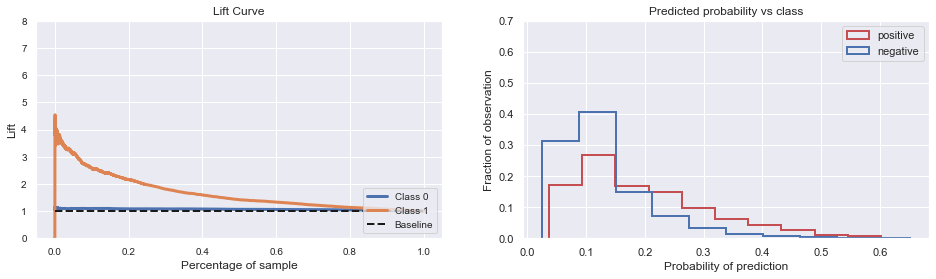

In [16]:
liftcurve_probahisto_score(trainmodel_cv, CatBoostClassifier(iterations=5,random_seed=43), 'CatB', 5, X_train, y_train, 8, 0.5)

Learning rate set to 0.5
0:	learn: 0.4848328	total: 11.9ms	remaining: 263ms
10:	learn: 0.3626679	total: 79.7ms	remaining: 86.9ms
20:	learn: 0.3552653	total: 147ms	remaining: 14ms
22:	learn: 0.3529765	total: 158ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4864378	total: 7.76ms	remaining: 171ms
10:	learn: 0.3671358	total: 73.1ms	remaining: 79.8ms
20:	learn: 0.3596966	total: 135ms	remaining: 12.8ms
22:	learn: 0.3583592	total: 147ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4850356	total: 4.88ms	remaining: 107ms
10:	learn: 0.3663590	total: 66.4ms	remaining: 72.4ms
20:	learn: 0.3608689	total: 121ms	remaining: 11.5ms
22:	learn: 0.3599470	total: 133ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4828942	total: 4.85ms	remaining: 107ms
10:	learn: 0.3618979	total: 88.4ms	remaining: 96.5ms
20:	learn: 0.3547384	total: 159ms	remaining: 15.1ms
22:	learn: 0.3536484	total: 171ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4867751	total: 4.54ms	remaining: 100ms
10:	le

,precison,recall,f1score,roc_auc,positive_in_top20pct,positive_in_top50pct
CatB,0.3,0.004,0.008,0.66,273.0,512.0


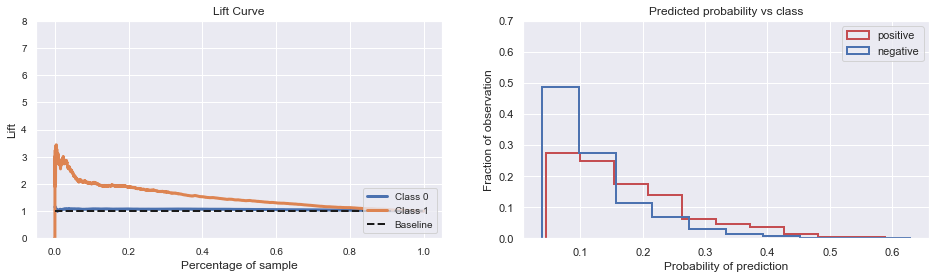

In [22]:
liftcurve_probahisto_score(trainmodel_cv, CatBoostClassifier(iterations=5,random_seed=43), 'CatB', 5, X_test, y_test, 8, 0.5)

In [19]:
def model_score(trainmethod, model, model_name, n, Xtest, ytest, ylim1, ylim2):
    
    # replace trainmethod with trainmodel_cv or trainmodel_os_cv
    final_model = trainmethod(model, n)
    
    # get prediction from test dataset
    yfinal = final_model.predict(Xtest)
    yfinal_proba = final_model.predict_proba(Xtest)[:,1]
    y_probas = final_model.predict_proba(Xtest)
    
    
    predProba_label = pd.DataFrame()
    #predProba_label['proba'] =(yfinal_proba - yfinal_proba.min())/(yfinal_proba.max() - yfinal_proba.min())
    predProba_label['proba'] = yfinal_proba
    predProba_label['label'] = ytest
    percent20 = round(len(ytest)*0.2)
    percent50 = round(len(ytest)*0.5)
    positive_in_top20pct = round(predProba_label,4).sort_values('proba', ascending=False).nlargest(percent20,'proba').label.sum()
    positive_in_top50pct = round(predProba_label,4).sort_values('proba', ascending=False).nlargest(percent50,'proba').label.sum()
    precision, recall, f1score, support = score(ytest, yfinal, pos_label=1,average='binary')
    roc_auc = roc_auc_score(ytest, yfinal_proba)
    dataframe = pd.DataFrame([precision, recall, f1score, roc_auc, positive_in_top20pct, positive_in_top50pct],
                       index=['precison','recall','f1score','roc_auc', 'positive_in_top20pct', 'positive_in_top50pct'], 
                       columns=[model_name]).T
    
    return round(dataframe, 3).positive_in_top20pct
    

In [20]:
[model_score(trainmodel_cv, CatBoostClassifier(iterations=i,random_seed=43), 'CatB', 5, X_test, y_test, 8, 0.5) for i in range(1,51)]

Learning rate set to 0.5
0:	learn: 0.4848328	total: 7.39ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4864378	total: 6.83ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4850356	total: 4.81ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4828942	total: 6.01ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4867751	total: 6.39ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4848328	total: 5.32ms	remaining: 5.32ms
1:	learn: 0.4173310	total: 13.2ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4864378	total: 5.14ms	remaining: 5.14ms
1:	learn: 0.4208651	total: 9.77ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4850356	total: 6.37ms	remaining: 6.37ms
1:	learn: 0.4188751	total: 10.5ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4828942	total: 4.8ms	remaining: 4.8ms
1:	learn: 0.4162073	total: 9.51ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4867751	total: 5.31ms	remaining: 5.31ms
1:	learn: 0.4215361	total: 9.77ms	remaining: 0us
Le

[CatB    246.0
 Name: positive_in_top20pct, dtype: float64,
 CatB    236.0
 Name: positive_in_top20pct, dtype: float64,
 CatB    250.0
 Name: positive_in_top20pct, dtype: float64,
 CatB    267.0
 Name: positive_in_top20pct, dtype: float64,
 CatB    267.0
 Name: positive_in_top20pct, dtype: float64,
 CatB    269.0
 Name: positive_in_top20pct, dtype: float64,
 CatB    271.0
 Name: positive_in_top20pct, dtype: float64,
 CatB    275.0
 Name: positive_in_top20pct, dtype: float64,
 CatB    268.0
 Name: positive_in_top20pct, dtype: float64,
 CatB    280.0
 Name: positive_in_top20pct, dtype: float64,
 CatB    265.0
 Name: positive_in_top20pct, dtype: float64,
 CatB    265.0
 Name: positive_in_top20pct, dtype: float64,
 CatB    270.0
 Name: positive_in_top20pct, dtype: float64,
 CatB    273.0
 Name: positive_in_top20pct, dtype: float64,
 CatB    271.0
 Name: positive_in_top20pct, dtype: float64,
 CatB    270.0
 Name: positive_in_top20pct, dtype: float64,
 CatB    274.0
 Name: positive_in_top20p

Learning rate set to 0.499073
0:	learn: 0.4851011	total: 11.5ms	remaining: 482ms
10:	learn: 0.3626827	total: 84.8ms	remaining: 247ms
20:	learn: 0.3552848	total: 145ms	remaining: 152ms
30:	learn: 0.3505471	total: 223ms	remaining: 86.4ms
40:	learn: 0.3457301	total: 288ms	remaining: 14ms
42:	learn: 0.3449926	total: 300ms	remaining: 0us
Learning rate set to 0.499094
0:	learn: 0.4866976	total: 4.5ms	remaining: 189ms
10:	learn: 0.3671503	total: 61.4ms	remaining: 179ms
20:	learn: 0.3590669	total: 125ms	remaining: 131ms
30:	learn: 0.3547538	total: 185ms	remaining: 71.6ms
40:	learn: 0.3496132	total: 245ms	remaining: 11.9ms
42:	learn: 0.3490468	total: 257ms	remaining: 0us
Learning rate set to 0.499094
0:	learn: 0.4852972	total: 4.86ms	remaining: 204ms
10:	learn: 0.3663734	total: 65.9ms	remaining: 192ms
20:	learn: 0.3608843	total: 123ms	remaining: 129ms
30:	learn: 0.3563493	total: 184ms	remaining: 71ms
40:	learn: 0.3490606	total: 244ms	remaining: 11.9ms
42:	learn: 0.3479688	total: 256ms	remaining

,precison,recall,f1score,roc_auc,positive_in_top20pct,positive_in_top50pct
CatB,0.353,0.008,0.016,0.657,284.0,508.0


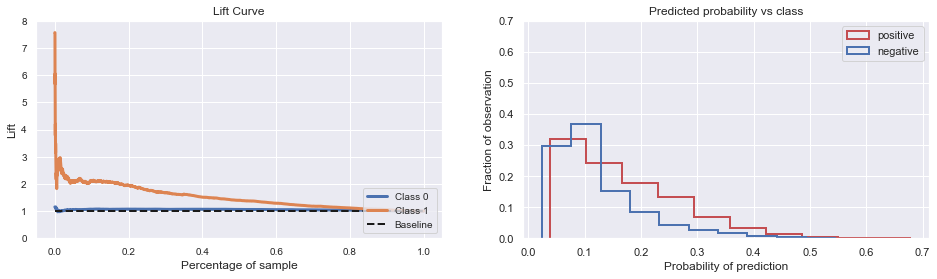

In [24]:
# as iterations = 43 gives us the best positive_in_top20pct 
liftcurve_probahisto_score(trainmodel_cv, CatBoostClassifier(iterations=43,random_seed=43), 'CatB', 5, X_test, y_test, 8, 0.5)